# Network analsys for SIR model

## Libraries

In [1]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from pathlib import Path
from PIL import Image
import shutil
from tqdm.notebook import tqdm

## Init


In [2]:
SEED:int = 2137
np.random.seed(SEED)
random.seed(SEED)
PATH_TO_FRAMES:Path = Path('../frames')
PATH_TO_FRAMES.mkdir(exist_ok=True, parents=True)
DATA_PATH:Path = Path('../data/bn-mouse-kasthuri_graph_v4.edges')
PATH_TO_PLOTS:Path = Path('../out/plots')
PATH_TO_PLOTS.mkdir(exist_ok=True, parents=True)

def setup_graph():
    print(f"Using dataset from {DATA_PATH.absolute()}")
    G = nx.read_edgelist(path=DATA_PATH, create_using=nx.Graph(), nodetype=int)
    G.remove_edges_from(nx.selfloop_edges(G))
    G = nx.k_core(G, k=2)
    print('nodes:', len(G.nodes()), 'and edges:', len(G.edges()))
    pos = nx.spring_layout(G, seed=SEED)

    infected_time_init:int = 0
    nx.set_node_attributes(G, 'S', 'state')
    nx.set_node_attributes(G, infected_time_init, 'infection_time')
    return G, pos

## Visualization function

In [3]:
def draw_graph(G, pos, step,experiment_num, path_to_frames, snapshot_mode=True, params=None):
    """
        Draw the SIR model graph with optional parameter display and save to file.

        Args:
        G (networkx.Graph): The graph to draw.
        pos (dict): The position dictionary for nodes.
        step (int): The current simulation step.
        experiment_num (str): Identifier for the experiment.
        path_to_frames (Path): Path where frames are stored.
        snapshot_mode (bool): Whether to save snapshot mode images.
        params (dict, optional): Simulation parameters to display in the title.
    """
    plt.figure(figsize=(8, 6))
    state_color = {'S': 'blue', 'I': 'red', 'R': 'green'}
    colors = [state_color[G.nodes[n]['state']] for n in G.nodes()]
    nx.draw_networkx(G, pos, node_color=colors, node_size=25, width=0.4, with_labels=False, edge_color=(0, 0, 0, 0.5))
    nx.draw
    plt.title(f'SIR at step {step}')
    # plt.legend(['Susceptible', 'Infected', 'Recovered'], loc='upper right')
    if params:
        title_text = f'SIR at step {step} (p={params["p"]}, tI={params["tI"]}, q={params["q"]})'
        number_of_nodes = len(G.nodes())
        handles = []
        for s, c in state_color.items():
            percentage = len([n for n in G.nodes() if G.nodes[n]["state"] == s]) / number_of_nodes
            patch = mpatches.Patch(color=c, label=f'{s} ({percentage:.3f})')
            handles.append(patch)
        plt.legend(handles=handles)
    else:
        title_text = f'SIR at step {step}'
        plt.legend(handles=[mpatches.Patch(color=c, label=s) for s, c in state_color.items()], loc='upper right')

    plt.title(title_text)

    output_path = path_to_frames / f'{experiment_num}-frame_{step}.png'
    plt.savefig(output_path)
    if snapshot_mode:
        snapshot_path = path_to_frames.parent / 'out' / f'{experiment_num}-snapshot_{step}.png'
        plt.savefig(snapshot_path)
    plt.close()

    
def plot_sir_data(results: dict):
    
    for exp_id, result in results.items():
        history = result['history']
        parameters = result['params']
        S, I, R = [h['S'] for h in history], [h['I'] for h in history], [h['R'] for h in history]
        susceptible_patch = mpatches.Patch(color='blue', label=f'Susceptible (p={parameters["p"]})')
        infected_patch = mpatches.Patch(color='red', label=f'Infected (tI={parameters["tI"]})')
        recovered_patch = mpatches.Patch(color='green', label=f'Recovered (q={parameters["q"]})')
        # Create a new figure for each experiment
        # plt.figure(figsize=(10, 8))
        fig, ax = plt.subplots(figsize=(10, 8))
        ax.plot(S, label='Susceptible', color='blue')
        ax.plot(I, label='Infected', color='red')
        ax.plot(R, label='Recovered', color='green')
        

        ax.legend(handles=[susceptible_patch, infected_patch, recovered_patch])
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Number of Nodes')
        ax.set_title(f'SIR - {exp_id} p = {parameters["p"]} tI= {parameters["tI"]} q = {parameters["q"]}')
        ax.grid(True)
        plt.savefig(PATH_TO_PLOTS / f'{exp_id}-{parameters["p"]}-{parameters["tI"]}-{parameters["q"]}.png')
        plt.close()
    
def create_gif(experiment_id, gif_name, duration=250, path_to_frames=Path('../frames'), path_out=Path('../out/gifs')):
    """
        Creates a GIF for a specific experiment.

        Args:
        experiment_id (str): Identifier for the experiment to create GIF.
        gif_name (str): The name of the output GIF file.
        duration (int): The duration each frame appears in the GIF (in milliseconds).
        path_to_frames (Path): Path to the directory containing frame images.
    """
    path_out.mkdir(exist_ok=True, parents=True)
    frames = []
    # Filter and sort frame files based on experiment_id and step number
    frame_files = sorted(path_to_frames.glob(f"{experiment_id}-frame_*.png"),
                         key=lambda x: int(x.stem.split('_')[1].split('.')[0]))

    for frame_path in frame_files:
        frames.append(Image.open(frame_path))
    
    if frames:
        # Save the frames as a GIF
        frames[0].save(path_out / f"{gif_name}.gif", format='GIF',
                       append_images=frames[1:], save_all=True, duration=duration, loop=0)
        print(f"GIF created: {path_out / gif_name}.gif")
    else:
        print(f"No frames found for the specified {experiment_id} experiment.")

## Progressing with infection

In [4]:
def attempt_infection(G, node, p):
    """Attempts to infect neighbors of a node based on infection probability p."""
    new_states = {}
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor]['state'] == 'S' and np.random.random() < p:
            new_states[neighbor] = 'I'
    return new_states

def manage_recovery(G, node, q, tI):
    """Determines whether an infected node recovers based on recovery probability q and minimum infection time tI."""
    should_recover = np.random.random() < q and G.nodes[node]['infection_time'] >= tI
    if should_recover:
        G.nodes[node]['infection_time'] = 0
        return 'R'
    else:
        G.nodes[node]['infection_time'] += 1
        return 'I'

def update_graph(G, p, tI, q):
    new_state = {}
    for node in G:
        current_state = G.nodes[node]['state']
        if current_state == 'I':
            new_state.update(attempt_infection(G, node, p))
            new_state[node] = manage_recovery(G, node, q, tI)
    # Update states
    for node, state in new_state.items():
        G.nodes[node]['state'] = state

def count_states(G)-> dict:
    states = {'S': 0, 'I': 0, 'R': 0}
    for node in G.nodes:
        states[G.nodes[node]['state']] += 1
    return states

def simulate_sir(G, pos, p, tI, q, steps, snapshot_interval:int=50, experiment_num:int=1):
    # To keep track of S, I, R counts
    history:list = []
    # To keep track of graphs for snapshots
    snapshots:list = []
    with tqdm(total=steps) as pbar:
        for step in range(steps):
            pbar.set_description(f"Running simulation {experiment_num} for {steps} steps")
            update_graph(G,p, tI, q)
            history.append(count_states(G))
            should_snapshot = step % snapshot_interval == 0 or step == steps - 1
            draw_graph(G, pos, step,experiment_num=experiment_num, path_to_frames=PATH_TO_FRAMES, snapshot_mode=should_snapshot, params={'p': p, 'tI': tI, 'q': q})
            if should_snapshot:
                snapshots.append(f'{experiment_num}-snapshot_{step}.png')
            pbar.update(1)
            # Check if any infected are left
            if count_states(G)['I'] == 0:
                break
        pbar.close()
    return history, snapshots

def run_experiments(G, pos, experiments, steps=500, snapshot_interval=50):
    results = {}
    experiment_num = 1
    for exp_id, params in experiments.items():
        # Reset the graph to all susceptible
        nx.set_node_attributes(G, 'S', 'state')
        # infect i0 nodes randomly
        infected_nodes = np.random.choice(a=list(G.nodes()), size= params['i0'], replace=False)
        for node in infected_nodes:
            G.nodes[node]['state'] = 'I'
            G.nodes[node]['infection_time'] = 0
        
        history, snapshots = simulate_sir(G, pos, params['p'], params['tI'], params['q'], steps, snapshot_interval, experiment_num=experiment_num)
        results[exp_id] = {'history': history, 'snapshots': snapshots, 'params': params}
        print(f"Experiment {exp_id} {experiment_num}  done!")
        experiment_num += 1
    return results

## Parameters and data

In [5]:
G, pos = setup_graph()
# Define different experiments with varying parameters
experiments = {
    #? p- Disease Transmission Probability
    #? tI - Duration of Infection
    #? q - Recovery Probability
    #? i0- Initial Number of Infected Individuals
    'exp1': {'p': 0.05, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp2': {'p': 0.1, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp3': {'p': 0.15, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp4': {'p': 0.2, 'tI': 3, 'q': 0.1, 'i0': 5},
    'exp5': {'p': 0.25, 'tI': 3, 'q': 0.1, 'i0': 5},
}
results = run_experiments(G, pos, experiments)

Using dataset from c:\Users\szink\Desktop\programming\NetworkAnalysis\assignment2\src\..\data\bn-mouse-kasthuri_graph_v4.edges
nodes: 477 and edges: 1026


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment exp1 1  done!


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment exp2 2  done!


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment exp3 3  done!


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment exp4 4  done!


  0%|          | 0/500 [00:00<?, ?it/s]

Experiment exp5 5  done!


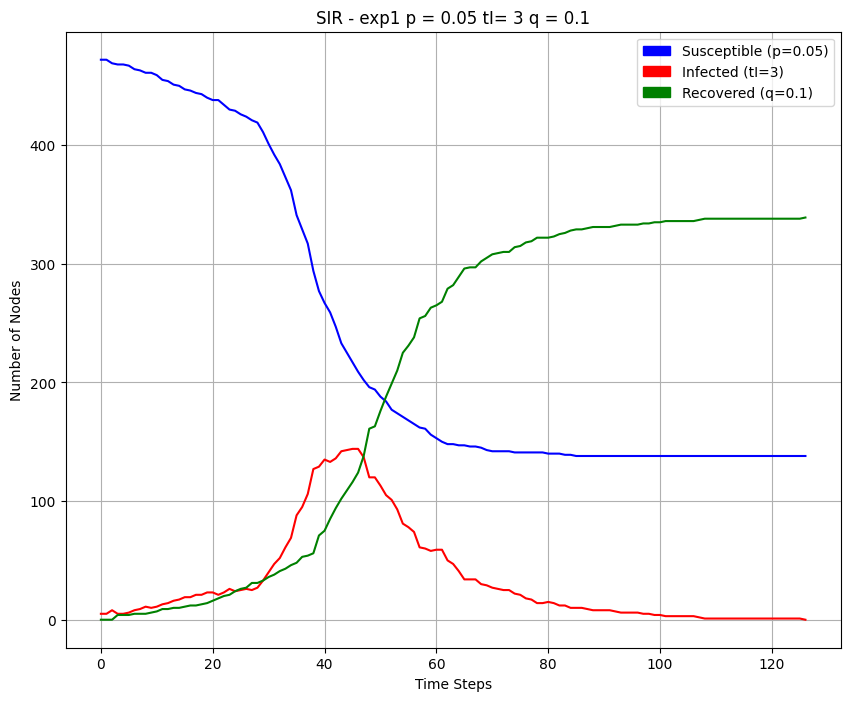

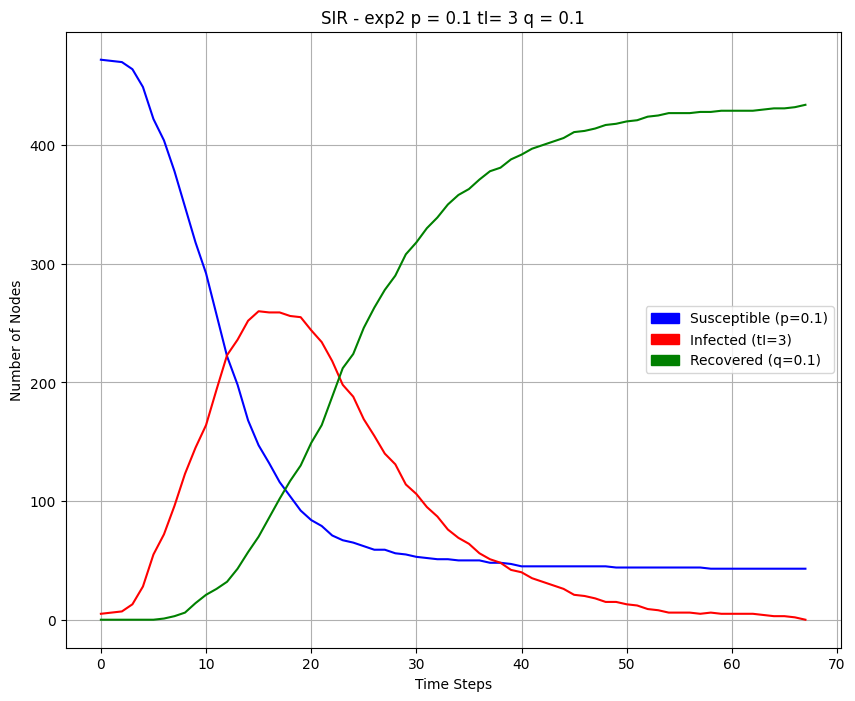

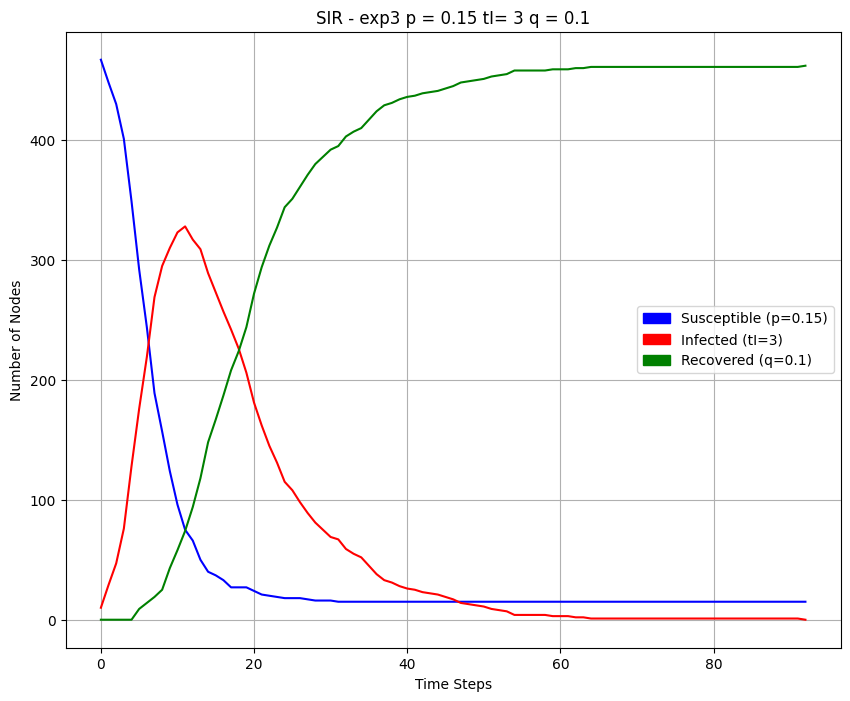

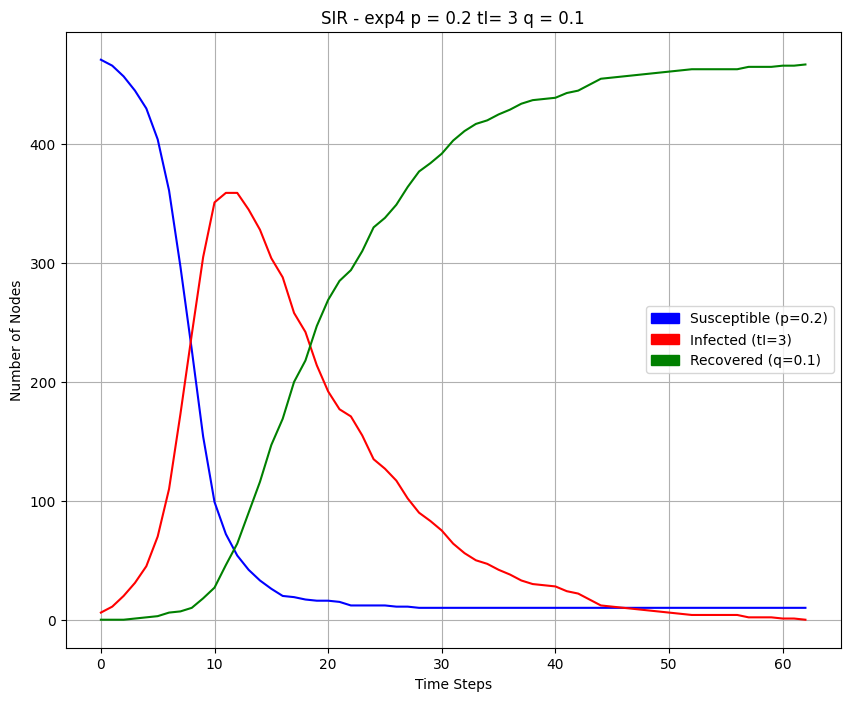

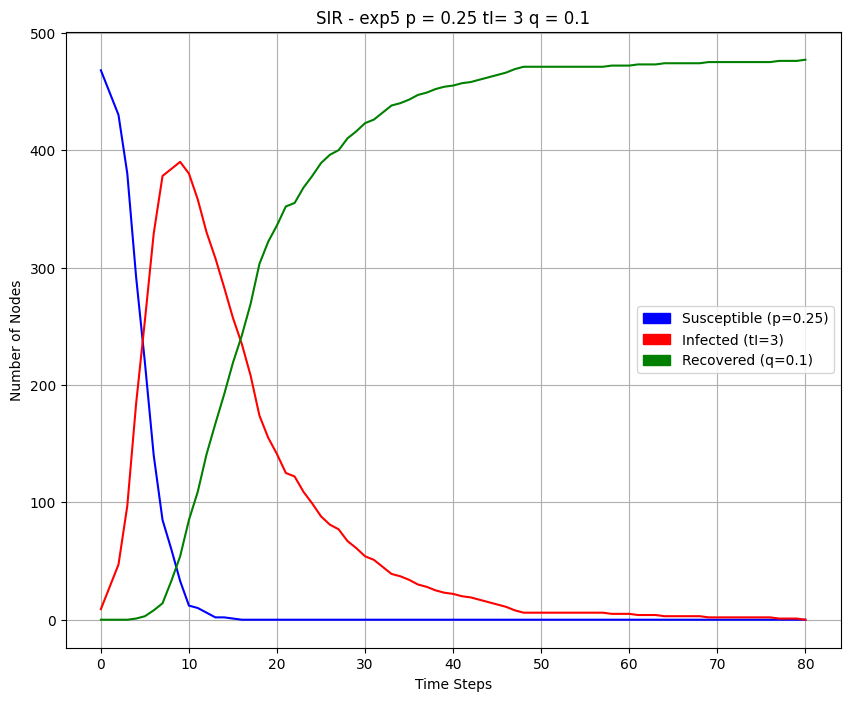

GIF created: ..\out\sir_simulation-0.gif
GIF created: ..\out\sir_simulation-1.gif
GIF created: ..\out\sir_simulation-2.gif
GIF created: ..\out\sir_simulation-3.gif
GIF created: ..\out\sir_simulation-4.gif


In [6]:
plot_sir_data(results)

# Create the GIF
for idx,_ in enumerate(results):
    create_gif(experiment_id=idx+1, gif_name=f'sir_simulation-{idx}', duration=150)
shutil.rmtree(path=PATH_TO_FRAMES)